# Method 7 - Best Ideas Medium Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['size_pct'] > (1 / 3)) & (best_ideas['size_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

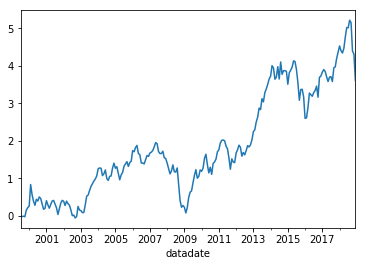

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.219845
2000-12-31   -0.013912
2001-12-31    0.175502
2002-12-31   -0.182812
2003-12-31    0.784683
2004-12-31    0.165676
2005-12-31    0.021111
2006-12-31    0.052776
2007-12-31   -0.021148
2008-12-31   -0.495398
2009-12-31    0.742014
2010-12-31    0.218248
2011-12-31   -0.107101
2012-12-31    0.249507
2013-12-31    0.538313
2014-12-31    0.043455
2015-12-31   -0.140779
2016-12-31    0.133365
2017-12-31    0.136067
2018-12-31   -0.142049
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     377.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.52e-99
Time:                        21:56:43   Log-Likelihood:                 503.09
No. Observations:                 234   AIC:                            -996.2
Df Residuals:                     229   BIC:                            -978.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.375      0.018       0.001       0.008
mktrf          0.9081      0.053     17.089      0.000       0.803       1.013
me             0.9729      0.062     15.739      0.000       0.851       1.095
ia             0.0068      0.094      0.073      0.942      -0.178       0.192
roe           -0.7132      0.080     -8.869      0.000      -0.872      -0.555
==============================================================================
Omnibus:                       77.866   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              580.981
Skew:                           1.075   Prob(JB):                    6.94e-127
Kurtosis:                      10.414   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     380.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.52e-100
Time:                        21:56:43   Log-Likelihood:                 503.09
No. Observations:                 234   AIC:                            -996.2
Df Residuals:                     229   BIC:                            -978.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.450      0.014       0.001       0.008
mktrf          0.9081      0.052     17.363      0.000       0.806       1.011
me             0.9729      0.165      5.889      0.000       0.649       1.297
ia             0.0068      0.136      0.050      0.960      -0.259       0.273
roe           -0.7132      0.121     -5.880      0.000      -0.951      -0.475
==============================================================================
Omnibus:                       77.866   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              580.981
Skew:                           1.075   Prob(JB):                    6.94e-127
Kurtosis:                      10.414   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     464.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.46e-108
Time:                        21:56:43   Log-Likelihood:                 503.09
No. Observations:                 234   AIC:                            -996.2
Df Residuals:                     229   BIC:                            -978.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.319      0.020       0.001       0.009
mktrf          0.9081      0.054     16.953      0.000       0.803       1.013
me             0.9729      0.172      5.656      0.000       0.636       1.310
ia             0.0068      0.121      0.057      0.955      -0.230       0.244
roe           -0.7132      0.129     -5.516      0.000      -0.967      -0.460
==============================================================================
Omnibus:                       77.866   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              580.981
Skew:                           1.075   Prob(JB):                    6.94e-127
Kurtosis:                      10.414   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     291.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.87e-97
Time:                        21:56:43   Log-Likelihood:                 499.92
No. Observations:                 234   AIC:                            -987.8
Df Residuals:                     228   BIC:                            -967.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.095      0.037       0.000       0.008
mktrf          1.0043      0.054     18.567      0.000       0.898       1.111
smb            0.9399      0.071     13.169      0.000       0.799       1.081
hml           -0.0138      0.084     -0.164      0.870      -0.180       0.152
rmw           -0.7092      0.095     -7.453      0.000      -0.897      -0.522
cma            0.3237      0.121      2.676      0.008       0.085       0.562
==============================================================================
Omnibus:                       44.397   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.952
Skew:                           0.651   Prob(JB):                     1.26e-42
Kurtosis:                       7.253   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     304.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.37e-99
Time:                        21:56:43   Log-Likelihood:                 499.92
No. Observations:                 234   AIC:                            -987.8
Df Residuals:                     228   BIC:                            -967.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      2.012      0.044       0.000       0.008
mktrf          1.0043      0.069     14.493      0.000       0.869       1.140
smb            0.9399      0.098      9.560      0.000       0.747       1.133
hml           -0.0138      0.135     -0.103      0.918      -0.278       0.250
rmw           -0.7092      0.147     -4.835      0.000      -0.997      -0.422
cma            0.3237      0.143      2.270      0.023       0.044       0.603
==============================================================================
Omnibus:                       44.397   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.952
Skew:                           0.651   Prob(JB):                     1.26e-42
Kurtosis:                       7.253   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     416.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.69e-112
Time:                        21:56:43   Log-Likelihood:                 499.92
No. Observations:                 234   AIC:                            -987.8
Df Residuals:                     228   BIC:                            -967.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.002      1.918      0.055   -9.08e-05       0.008
mktrf          1.0043      0.075     13.377      0.000       0.857       1.151
smb            0.9399      0.108      8.722      0.000       0.729       1.151
hml           -0.0138      0.125     -0.110      0.912      -0.259       0.232
rmw           -0.7092      0.139     -5.107      0.000      -0.981      -0.437
cma            0.3237      0.135      2.404      0.016       0.060       0.588
==============================================================================
Omnibus:                       44.397   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.952
Skew:                           0.651   Prob(JB):                     1.26e-42
Kurtosis:                       7.253   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     313.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-91
Time:                        21:56:43   Log-Likelihood:                 484.39
No. Observations:                 234   AIC:                            -958.8
Df Residuals:                     229   BIC:                            -941.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.172      0.243      -0.002       0.006
mktrf          1.0544      0.053     19.894      0.000       0.950       1.159
smb            1.2427      0.066     18.785      0.000       1.112       1.373
hml            0.0694      0.066      1.056      0.292      -0.060       0.199
umd           -0.1955      0.043     -4.533      0.000      -0.280      -0.110
==============================================================================
Omnibus:                       92.590   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              693.550
Skew:                           1.342   Prob(JB):                    2.50e-151
Kurtosis:                      10.995   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     394.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.81e-101
Time:                        21:56:43   Log-Likelihood:                 484.39
No. Observations:                 234   AIC:                            -958.8
Df Residuals:                     229   BIC:                            -941.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.316      0.188      -0.001       0.006
mktrf          1.0544      0.055     19.122      0.000       0.946       1.162
smb            1.2427      0.165      7.549      0.000       0.920       1.565
hml            0.0694      0.105      0.661      0.509      -0.136       0.275
umd           -0.1955      0.063     -3.093      0.002      -0.319      -0.072
==============================================================================
Omnibus:                       92.590   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              693.550
Skew:                           1.342   Prob(JB):                    2.50e-151
Kurtosis:                      10.995   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     473.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.93e-109
Time:                        21:56:43   Log-Likelihood:                 484.39
No. Observations:                 234   AIC:                            -958.8
Df Residuals:                     229   BIC:                            -941.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.299      0.194      -0.001       0.006
mktrf          1.0544      0.059     17.981      0.000       0.939       1.169
smb            1.2427      0.165      7.540      0.000       0.920       1.566
hml            0.0694      0.101      0.685      0.493      -0.129       0.268
umd           -0.1955      0.064     -3.033      0.002      -0.322      -0.069
==============================================================================
Omnibus:                       92.590   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              693.550
Skew:                           1.342   Prob(JB):                    2.50e-151
Kurtosis:                      10.995   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     176.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.77e-48
Time:                        21:56:43   Log-Likelihood:                 233.71
No. Observations:                 120   AIC:                            -457.4
Df Residuals:                     115   BIC:                            -443.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.003      2.008      0.047    9.11e-05       0.013
mktrf          0.8503      0.091      9.358      0.000       0.670       1.030
me             1.0274      0.090     11.448      0.000       0.850       1.205
ia            -0.0837      0.141     -0.595      0.553      -0.362       0.195
roe           -0.7248      0.124     -5.827      0.000      -0.971      -0.478
==============================================================================
Omnibus:                       28.249   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.362
Skew:                           0.710   Prob(JB):                     1.32e-23
Kurtosis:                       7.365   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     198.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-50
Time:                        21:56:43   Log-Likelihood:                 233.71
No. Observations:                 120   AIC:                            -457.4
Df Residuals:                     115   BIC:                            -443.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.003      2.135      0.033       0.001       0.013
mktrf          0.8503      0.060     14.084      0.000       0.732       0.969
me             1.0274      0.195      5.282      0.000       0.646       1.409
ia            -0.0837      0.190     -0.441      0.659      -0.456       0.288
roe           -0.7248      0.190     -3.806      0.000      -1.098      -0.352
==============================================================================
Omnibus:                       28.249   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.362
Skew:                           0.710   Prob(JB):                     1.32e-23
Kurtosis:                       7.365   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     263.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.01e-57
Time:                        21:56:43   Log-Likelihood:                 233.71
No. Observations:                 120   AIC:                            -457.4
Df Residuals:                     115   BIC:                            -443.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.003      2.009      0.045       0.000       0.013
mktrf          0.8503      0.059     14.529      0.000       0.736       0.965
me             1.0274      0.206      4.997      0.000       0.624       1.430
ia            -0.0837      0.168     -0.497      0.619      -0.413       0.246
roe           -0.7248      0.207     -3.495      0.000      -1.131      -0.318
==============================================================================
Omnibus:                       28.249   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.362
Skew:                           0.710   Prob(JB):                     1.32e-23
Kurtosis:                       7.365   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     138.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.18e-47
Time:                        21:56:43   Log-Likelihood:                 233.39
No. Observations:                 120   AIC:                            -454.8
Df Residuals:                     114   BIC:                            -438.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.003      2.273      0.025       0.001       0.015
mktrf          1.0034      0.096     10.399      0.000       0.812       1.195
smb            1.0024      0.109      9.172      0.000       0.786       1.219
hml           -0.0477      0.134     -0.356      0.722      -0.313       0.218
rmw           -0.6867      0.158     -4.348      0.000      -0.999      -0.374
cma            0.3315      0.173      1.916      0.058      -0.011       0.674
==============================================================================
Omnibus:                       12.246   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.154
Skew:                           0.248   Prob(JB):                     2.83e-07
Kurtosis:                       5.405   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     186.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.59e-53
Time:                        21:56:43   Log-Likelihood:                 233.39
No. Observations:                 120   AIC:                            -454.8
Df Residuals:                     114   BIC:                            -438.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.003      2.388      0.017       0.001       0.014
mktrf          1.0034      0.132      7.609      0.000       0.745       1.262
smb            1.0024      0.138      7.273      0.000       0.732       1.272
hml           -0.0477      0.229     -0.208      0.835      -0.497       0.402
rmw           -0.6867      0.255     -2.691      0.007      -1.187      -0.187
cma            0.3315      0.192      1.728      0.084      -0.045       0.707
==============================================================================
Omnibus:                       12.246   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.154
Skew:                           0.248   Prob(JB):                     2.83e-07
Kurtosis:                       5.405   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     341.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.15e-67
Time:                        21:56:43   Log-Likelihood:                 233.39
No. Observations:                 120   AIC:                            -454.8
Df Residuals:                     114   BIC:                            -438.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.004      2.253      0.024       0.001       0.015
mktrf          1.0034      0.141      7.113      0.000       0.727       1.280
smb            1.0024      0.151      6.618      0.000       0.705       1.299
hml           -0.0477      0.232     -0.206      0.837      -0.503       0.407
rmw           -0.6867      0.264     -2.601      0.009      -1.204      -0.169
cma            0.3315      0.177      1.869      0.062      -0.016       0.679
==============================================================================
Omnibus:                       12.246   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.154
Skew:                           0.248   Prob(JB):                     2.83e-07
Kurtosis:                       5.405   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     156.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.39e-45
Time:                        21:56:43   Log-Likelihood:                 227.77
No. Observations:                 120   AIC:                            -445.5
Df Residuals:                     115   BIC:                            -431.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      1.525      0.130      -0.002       0.012
mktrf          1.0494      0.084     12.476      0.000       0.883       1.216
smb            1.3307      0.096     13.896      0.000       1.141       1.520
hml            0.0401      0.096      0.418      0.676      -0.150       0.230
umd           -0.2036      0.059     -3.442      0.001      -0.321      -0.086
==============================================================================
Omnibus:                       34.439   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.012
Skew:                           0.941   Prob(JB):                     5.28e-27
Kurtosis:                       7.545   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     231.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.46e-54
Time:                        21:56:43   Log-Likelihood:                 227.77
No. Observations:                 120   AIC:                            -445.5
Df Residuals:                     115   BIC:                            -431.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      2.227      0.026       0.001       0.010
mktrf          1.0494      0.071     14.698      0.000       0.909       1.189
smb            1.3307      0.188      7.064      0.000       0.962       1.700
hml            0.0401      0.151      0.267      0.790      -0.255       0.335
umd           -0.2036      0.074     -2.753      0.006      -0.348      -0.059
==============================================================================
Omnibus:                       34.439   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.012
Skew:                           0.941   Prob(JB):                     5.28e-27
Kurtosis:                       7.545   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     314.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.09e-61
Time:                        21:56:43   Log-Likelihood:                 227.77
No. Observations:                 120   AIC:                            -445.5
Df Residuals:                     115   BIC:                            -431.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      2.421      0.015       0.001       0.010
mktrf          1.0494      0.076     13.837      0.000       0.901       1.198
smb            1.3307      0.189      7.034      0.000       0.960       1.702
hml            0.0401      0.158      0.253      0.800      -0.270       0.351
umd           -0.2036      0.072     -2.823      0.005      -0.345      -0.062
==============================================================================
Omnibus:                       34.439   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.012
Skew:                           0.941   Prob(JB):                     5.28e-27
Kurtosis:                       7.545   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     277.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.50e-56
Time:                        21:56:43   Log-Likelihood:                 298.96
No. Observations:                 114   AIC:                            -587.9
Df Residuals:                     109   BIC:                            -574.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.505      0.615      -0.003       0.004
mktrf          1.0515      0.053     19.902      0.000       0.947       1.156
me             0.6993      0.082      8.573      0.000       0.538       0.861
ia             0.1940      0.113      1.715      0.089      -0.030       0.418
roe           -0.7289      0.099     -7.331      0.000      -0.926      -0.532
==============================================================================
Omnibus:                        2.548   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                2.224
Skew:                           0.341   Prob(JB):                        0.329
Kurtosis:                       3.057   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     755.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.84e-78
Time:                        21:56:43   Log-Likelihood:                 298.96
No. Observations:                 114   AIC:                            -587.9
Df Residuals:                     109   BIC:                            -574.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.568      0.570      -0.002       0.004
mktrf          1.0515      0.043     24.668      0.000       0.968       1.135
me             0.6993      0.048     14.440      0.000       0.604       0.794
ia             0.1940      0.119      1.634      0.102      -0.039       0.427
roe           -0.7289      0.097     -7.507      0.000      -0.919      -0.539
==============================================================================
Omnibus:                        2.548   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                2.224
Skew:                           0.341   Prob(JB):                        0.329
Kurtosis:                       3.057   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     768.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.32e-79
Time:                        21:56:43   Log-Likelihood:                 298.96
No. Observations:                 114   AIC:                            -587.9
Df Residuals:                     109   BIC:                            -574.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.590      0.555      -0.002       0.004
mktrf          1.0515      0.037     28.686      0.000       0.980       1.123
me             0.6993      0.043     16.313      0.000       0.615       0.783
ia             0.1940      0.135      1.439      0.150      -0.070       0.458
roe           -0.7289      0.080     -9.106      0.000      -0.886      -0.572
==============================================================================
Omnibus:                        2.548   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                2.224
Skew:                           0.341   Prob(JB):                        0.329
Kurtosis:                       3.057   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     199.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.84e-53
Time:                        21:56:43   Log-Likelihood:                 293.84
No. Observations:                 114   AIC:                            -575.7
Df Residuals:                     108   BIC:                            -559.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.496      0.621      -0.005       0.003
mktrf          1.0961      0.053     20.701      0.000       0.991       1.201
smb            0.6945      0.086      8.080      0.000       0.524       0.865
hml            0.1290      0.110      1.177      0.242      -0.088       0.346
rmw           -0.6753      0.134     -5.031      0.000      -0.941      -0.409
cma            0.1755      0.170      1.030      0.305      -0.162       0.513
==============================================================================
Omnibus:                        4.414   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.794
Skew:                           0.388   Prob(JB):                        0.150
Kurtosis:                       3.442   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     255.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.63e-58
Time:                        21:56:43   Log-Likelihood:                 293.84
No. Observations:                 114   AIC:                            -575.7
Df Residuals:                     108   BIC:                            -559.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.519      0.604      -0.004       0.003
mktrf          1.0961      0.051     21.387      0.000       0.996       1.197
smb            0.6945      0.058     11.978      0.000       0.581       0.808
hml            0.1290      0.088      1.460      0.144      -0.044       0.302
rmw           -0.6753      0.158     -4.287      0.000      -0.984      -0.367
cma            0.1755      0.174      1.007      0.314      -0.166       0.517
==============================================================================
Omnibus:                        4.414   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.794
Skew:                           0.388   Prob(JB):                        0.150
Kurtosis:                       3.442   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     413.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-68
Time:                        21:56:43   Log-Likelihood:                 293.84
No. Observations:                 114   AIC:                            -575.7
Df Residuals:                     108   BIC:                            -559.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.002     -0.524      0.600      -0.004       0.003
mktrf          1.0961      0.054     20.370      0.000       0.991       1.202
smb            0.6945      0.057     12.203      0.000       0.583       0.806
hml            0.1290      0.087      1.478      0.140      -0.042       0.300
rmw           -0.6753      0.161     -4.198      0.000      -0.991      -0.360
cma            0.1755      0.201      0.874      0.382      -0.218       0.569
==============================================================================
Omnibus:                        4.414   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.794
Skew:                           0.388   Prob(JB):                        0.150
Kurtosis:                       3.442   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     206.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.01e-50
Time:                        21:56:43   Log-Likelihood:                 283.76
No. Observations:                 114   AIC:                            -557.5
Df Residuals:                     109   BIC:                            -543.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.718      0.474      -0.006       0.003
mktrf          1.1226      0.057     19.621      0.000       1.009       1.236
smb            0.8448      0.089      9.470      0.000       0.668       1.022
hml            0.2685      0.092      2.923      0.004       0.086       0.451
umd           -0.1717      0.069     -2.477      0.015      -0.309      -0.034
==============================================================================
Omnibus:                        5.589   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.738
Skew:                           0.337   Prob(JB):                       0.0568
Kurtosis:                       3.868   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     284.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.11e-56
Time:                        21:56:43   Log-Likelihood:                 283.76
No. Observations:                 114   AIC:                            -557.5
Df Residuals:                     109   BIC:                            -543.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.762      0.446      -0.005       0.002
mktrf          1.1226      0.052     21.712      0.000       1.021       1.224
smb            0.8448      0.069     12.291      0.000       0.710       0.980
hml            0.2685      0.093      2.892      0.004       0.087       0.451
umd           -0.1717      0.044     -3.893      0.000      -0.258      -0.085
==============================================================================
Omnibus:                        5.589   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.738
Skew:                           0.337   Prob(JB):                       0.0568
Kurtosis:                       3.868   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     346.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.36e-61
Time:                        21:56:43   Log-Likelihood:                 283.76
No. Observations:                 114   AIC:                            -557.5
Df Residuals:                     109   BIC:                            -543.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.709      0.478      -0.006       0.003
mktrf          1.1226      0.050     22.326      0.000       1.024       1.221
smb            0.8448      0.048     17.715      0.000       0.751       0.938
hml            0.2685      0.086      3.115      0.002       0.100       0.438
umd           -0.1717      0.036     -4.764      0.000      -0.242      -0.101
==============================================================================
Omnibus:                        5.589   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.738
Skew:                           0.337   Prob(JB):                       0.0568
Kurtosis:                       3.868   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""